In [310]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from scipy.signal import firwin,freqz,residuez

np.set_printoptions(precision=4, suppress=True)

plt.rcParams.update({
    'figure.facecolor': 'black',
    'axes.facecolor': 'black',
    'axes.edgecolor': 'white',
    'axes.labelcolor': 'white',
    'xtick.color': 'white',
    'ytick.color': 'white',
    'text.color': 'white',
    'grid.color': 'gray',
    'lines.linewidth': 2
})

In [311]:
USE_TEST_SIGNAL = True        # True = synthetic tone, False = WAV
TEST_SIGNAL_FREQ = 500         # Hz
TEST_SIGNAL_DUR  = 2.0         # sec
fs = 8000

CUTOFF_HZ = 1000                # Hz
FILTER_ORDER = 1               # for IIR
FIR_TAPS = 21                 # for FIR
USE_IIR = False                 # NOSONAR True=IIR, False=FIR
FILTER_TYPE = "lowpass"       # "lowpass" or "highpass"

ADD_NOISE = True               # enable noise addition
NOISE_TYPE = "Hum"             # "White", "Hum", "None"
NOISE_LEVEL = 1.0              # relative noise power (0.0–1.0)
NOISE_FREQUENCY = 10

AUDIO_FILE = "audio1.wav"

In [312]:
def add_noise(audio, sr, noise_t, noise_lvl, noise_freq=60):
    if noise_t == 'None' or noise_lvl <= 0:
        return audio

    sig_std = np.sqrt(np.mean(audio**2))
    noise_amp = noise_lvl * sig_std
    # 60 Hz hum tone
    t = np.arange(len(audio)) / sr
    noise = noise_amp * np.sin(2*np.pi*noise_freq*t)

    return audio + noise

In [313]:
def _butter_analog_poles(order):
    poles = []
    for k in range(1, order+1):
        theta = (2*k + order -1) * np.pi / (2*order)
        poles.append(np.exp(1j*theta))
    return np.array(poles)


def design_butter_iir(filter_type, cutoff_hz, sr, order):
    if cutoff_hz <= 0 or cutoff_hz >= sr/2:
        raise ValueError('cutoff must be within (0, Nyquist)')
    
    fs = float(sr)
    omega_c = 2*fs * np.tan(np.pi*cutoff_hz/fs)

    p_proto = _butter_analog_poles(order)
    p_analog = p_proto * omega_c

    a_s = np.real_if_close(np.poly(p_analog))

    # Bilinear transform
    z_poles = (1 + p_analog/(2*fs)) / (1 - p_analog/(2*fs))


    # zeros
    if filter_type == 'lowpass':
        z_zeros = np.array([-1.0]*order)
    else:  # highpass
        z_zeros = np.array([1.0]*order)

    a = np.real_if_close(np.poly(z_poles))
    b = np.real_if_close(np.poly(z_zeros))

    z_eval = 1.0 if filter_type=='lowpass' else -1.0
    num = np.polyval(b, z_eval)
    den = np.polyval(a, z_eval)
    b = b * (np.real(den/num))

    return b.real, a.real, a_s.real, p_analog

In [314]:
def design_fir_rectangular(filter_type, cutoff, sr, numtaps=101):
    omega = 2 * np.pi * cutoff / sr
    alpha = (numtaps - 1) / 2
    n = np.arange(numtaps)
    
    h_lp = (omega / np.pi) * np.sinc((omega / np.pi) * (n - alpha))
    
    if filter_type == "lowpass":
        h = h_lp / np.sum(h_lp)
    else: # highpass
        h = -h_lp
        h[int(alpha)] += 1
        h = h / np.sum(h * ((-1) ** n))
    return h, np.array([1.0])

In [315]:
def apply_filter_direct(b, a, x):
    b = np.asarray(b, dtype=float)
    a = np.asarray(a, dtype=float)
    x = np.asarray(x, dtype=float)

    M = len(b) - 1
    N = len(a) - 1
    y = np.zeros_like(x, dtype=float)

    for n in range(len(x)):
        acc = 0.0
        for i in range(M + 1):
            if n - i >= 0:
                acc += b[i] * x[n - i]
        for j in range(1, N + 1):
            if n - j >= 0:
                acc -= a[j] * y[n - j]
        y[n] = acc / a[0]

    return y

In [316]:
if USE_TEST_SIGNAL:
    t = np.linspace(0, TEST_SIGNAL_DUR, int(fs * TEST_SIGNAL_DUR), endpoint=False)
    audio = 0.8 * np.sin(2*np.pi * TEST_SIGNAL_FREQ * t)
else:
    audio, fs = sf.read(AUDIO_FILE)
    if audio.ndim > 1: audio = audio.mean(axis=1)

audio_noisy = add_noise(audio, fs, NOISE_TYPE, NOISE_LEVEL, NOISE_FREQUENCY)

if USE_IIR:
    b, a, as_coeffs, p_an = design_butter_iir(FILTER_TYPE, CUTOFF_HZ, fs, FILTER_ORDER)
    filter_label = "IIR Butterworth"
else:
    b, a = design_fir_rectangular(FILTER_TYPE, CUTOFF_HZ, fs, FIR_TAPS)
    filter_label = "FIR Rectangular"

filtered = apply_filter_direct(b, a, audio_noisy)
filtered = filtered / (np.max(np.abs(filtered)) + 1e-12) # Normalize

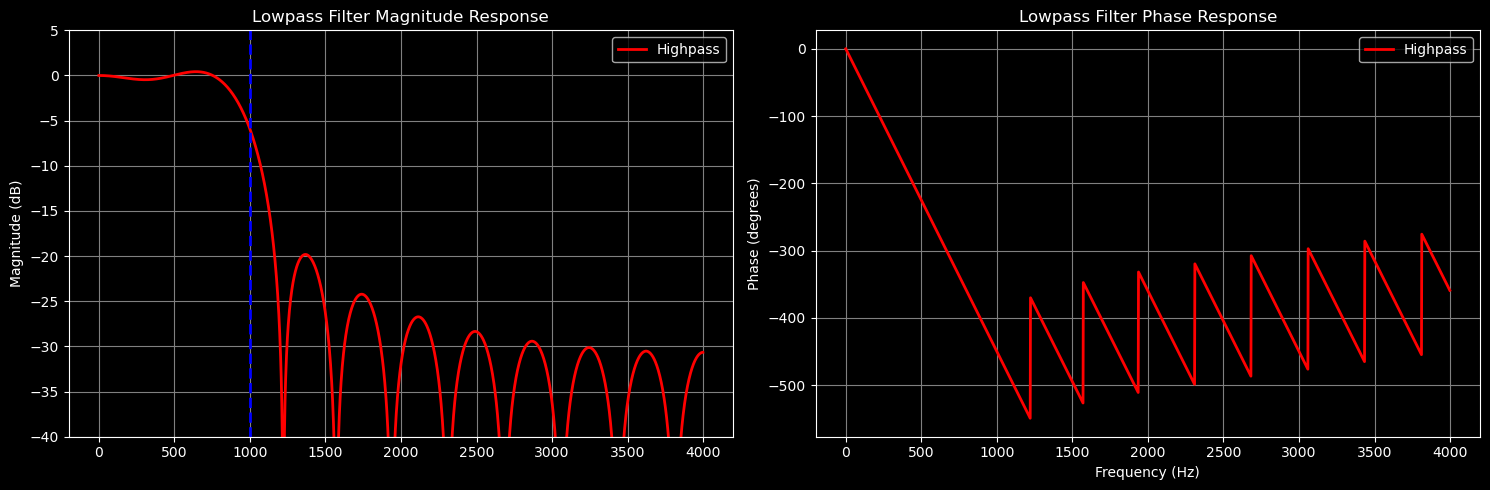

In [317]:
w, H_hp = freqz(b,a, worN=2048, fs=fs)

# --- Plot ---
plt.figure(figsize=(15, 5), facecolor='black')

# Magnitude Response
plt.subplot(1,2, 1)
plt.plot(w, 20*np.log10(np.abs(H_hp)), 'r', linewidth=2)
plt.grid(True)
plt.axvline(CUTOFF_HZ, color='b', linestyle='--')
plt.ylabel('Magnitude (dB)')
plt.title(f"{FILTER_TYPE.capitalize()} Filter Magnitude Response")
plt.legend(['Highpass'])
plt.ylim([-40, 5])

# Phase Response
plt.subplot(1, 2, 2)
plt.plot(w, np.unwrap(np.angle(H_hp)) * 180 / np.pi, 'r', linewidth=2)
plt.grid(True)
plt.title(f"{FILTER_TYPE.capitalize()} Filter Phase Response")
plt.xlabel('Frequency (Hz)')
plt.ylabel('Phase (degrees)')
plt.legend(['Highpass'])

plt.tight_layout()
plt.show()

In [318]:
def plot_pz_splane(analog_poles):
    plt.figure(figsize=(6, 6))
    plt.axhline(0,color="gray",zorder=1)
    plt.axvline(0,color="gray",zorder=1)

    plt.scatter(analog_poles.real, analog_poles.imag,color='red', marker='x', s=80, label="Analog Poles",zorder=9)

    plt.title("S-Plane Poles (Analog Prototype)")
    plt.xlabel("Real(s)")
    plt.ylabel("Imag(s)")
    # plt.grid(True)
    plt.legend()
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

In [319]:
def plot_pz_zplane(b, a):
    zeros = np.roots(b)
    poles = np.roots(a)

    plt.figure(figsize=(6, 6))
    plt.axhline(0, color='gray',zorder=1)
    plt.axvline(0, color='gray',zorder=1)

    # Unit circle
    theta = np.linspace(0, 2*np.pi, 400)
    plt.plot(np.cos(theta), np.sin(theta), 'k--', linewidth=1)

    # Mark poles & zeros
    plt.scatter(zeros.real, zeros.imag, edgecolors='blue',facecolors='none', s=70, label="Zeros",zorder=5)
    plt.scatter(poles.real, poles.imag, color='red',marker='x', s=80, label="Poles")

    plt.title("Z-Plane Poles and Zeros")
    plt.xlabel("Real")
    plt.ylabel("Imag")
    # plt.grid(True)
    plt.legend()
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

In [320]:
def plot_pz_zplane(b, a):
    zeros = np.roots(b)
    poles = np.roots(a)

    plt.figure(figsize=(6, 6))

    # Unit circle
    circle = plt.Circle((0,0), 1, color='white', fill=False, linestyle='--')
    plt.gca().add_artist(circle)

    # Mark poles & zeros
    plt.scatter(zeros.real, zeros.imag, marker='o', edgecolors='blue', facecolors='none', label='Zeros')
    plt.scatter(poles.real, poles.imag, marker='x', color='red', label='Poles')

    plt.title("Z-Plane Poles and Zeros")
    plt.xlabel("Real")
    plt.ylabel("Imag")
    plt.legend()
    plt.axis('equal')
    plt.show()

In [321]:
from sympy import symbols, simplify, latex, init_printing
from IPython.display import display, Math, Markdown,HTML

In [ ]:
if USE_IIR:
    if FILTER_TYPE == "lowpass":
        bs = [as_coeffs[-1]]
    else:
        bs = [1.0] + [0.0] * FILTER_ORDER
        
    display(Markdown(rf"""<h1 style="font-size:{"50px"}; color:{"#2e7d32"}; text-align:center;">Designing {FILTER_TYPE} IIR Butterworth</h2>"""))

    s = symbols('s')
    num_s = sum(np.round(bs[i],4) * s**(len(bs)-1-i) for i in range(len(bs)))
    den_s = sum(np.round(as_coeffs[i],4) * s**(len(as_coeffs)-1-i) for i in range(len(as_coeffs)))
    H_s = simplify(num_s / den_s)
    
    display(Markdown(rf"## Analog Butterworth {FILTER_TYPE.upper()} Filter Transfer Function: H(s)"))
    display(Math(r"\displaystyle {\Large " + latex(H_s) + "}"))

    z = symbols('z')
    num_z = sum(np.round(b[k],4) * z**(-k) for k in range(len(b)))
    den_z = sum(np.round(a[k],4) * z**(-k) for k in range(len(a)))
    H_z = simplify(num_z / den_z)
    
    display(Markdown(rf"## Digital Butterworth {FILTER_TYPE.upper()} Filter Transfer Function: H(z) "))
    display(Math(r"\displaystyle {\large " + latex(H_z) + "}"))

    print("\nDiscrete Numerator Coefficients (bz):")
    print(f"   {np.array2string(b, formatter={'all':lambda x: f'{x:.4e}'})}")

    print("\nDiscrete Denominator Coefficients (az):")
    print(f"   {a}")
    
else:
    # ===============================
    # FIR Filter
    # ===============================
    print(f"\nDesigning {FILTER_TYPE} FIR filter")

    b, a = design_fir_rectangular(FILTER_TYPE, CUTOFF_HZ, fs, FIR_TAPS)

    z = symbols('z')

    H_z = simplify(sum(np.round(b[k],4) * z**(-k) for k in range(len(b))))
    print("\n### FIR Transfer Function H(z) ###")
    display(Math(r"\displaystyle {\Huge " + latex(H_z) + "}"))



Designing lowpass FIR filter

### FIR Transfer Function H(z) ###


<IPython.core.display.Math object>

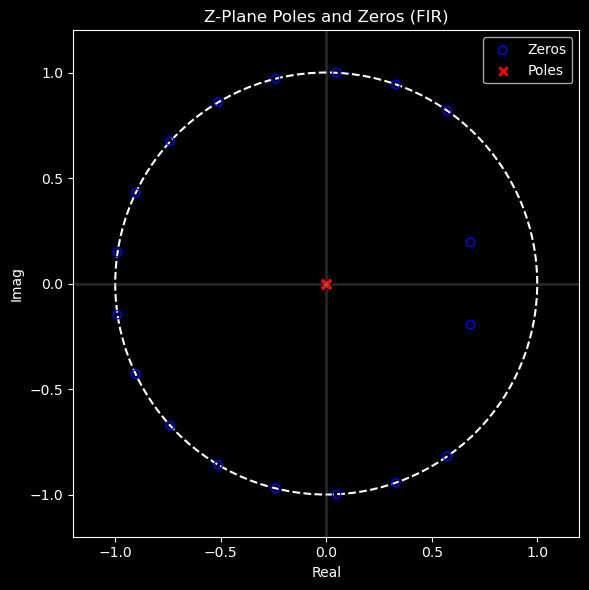

In [ ]:
if USE_IIR:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # --- S-Plane (Analog) ---
    if p_an is not None:
        ax1.axhline(0, color="gray", alpha=0.3)
        ax1.axvline(0, color="gray", alpha=0.3)
        ax1.scatter(p_an.real, p_an.imag, color='red', marker='x', s=80, label="Analog Poles", zorder=9)
        ax1.set_title("S-Plane Poles (Analog Prototype)")
        ax1.set_xlabel("Real(s)")
        ax1.set_ylabel("Imag(s)")
        ax1.legend()
        ax1.axis('equal')
    else:
        ax1.axis('off')  

# --- Z-Plane (Digital) ---
zeros = np.roots(b)
poles = np.roots(a)

ax2.axhline(0, color='gray', alpha=0.3)
ax2.axvline(0, color='gray', alpha=0.3)

# Unit circle
circle = plt.Circle((0,0), 1, edgecolor='white', fill=False, linestyle='--')
ax2.add_artist(circle)

# Plot poles & zeros
ax2.scatter(zeros.real, zeros.imag, marker='o', edgecolors='blue', facecolors='none', label='Zeros')
ax2.scatter(poles.real, poles.imag, marker='x', color='red', label='Poles')

ax2.set_xlim(-1.2, 1.2)
ax2.set_ylim(-1.2, 1.2)
ax2.set_aspect('equal', 'box')
ax2.set_title("Z-Plane Poles and Zeros")
ax2.set_xlabel("Real")
ax2.set_ylabel("Imag")
ax2.legend()


fig, ax = plt.subplots(figsize=(6,6))

zeros = np.roots(b)
poles = np.zeros(len(b)-1)  # FIR poles at origin

ax.axhline(0, color='gray', alpha=0.3)
ax.axvline(0, color='gray', alpha=0.3)

# Unit circle
circle = plt.Circle((0,0), 1, edgecolor='White', fill=False, linestyle='--', lw=1.5)
ax.add_artist(circle)

# Plot poles & zeros
ax.scatter(zeros.real, zeros.imag, marker='o', edgecolors='blue', facecolors='none', label='Zeros')
ax.scatter(poles.real, poles.imag, marker='x', color='red', label='Poles')

ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)
ax.set_aspect('equal', 'box')
ax.set_title("Z-Plane Poles and Zeros (FIR)")
ax.set_xlabel("Real")
ax.set_ylabel("Imag")
ax.legend()

plt.tight_layout()
plt.show()
